### 네이버 주가예측

In [1]:
import time
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [2]:
stock_price = pd.DataFrame() # 주가 데이터를 저장할 dataframe

In [3]:
stock_number = "035420"
pages = 50

In [4]:
for page in range(1, pages+1):
    url = f'https://finance.naver.com/item/sise_day.nhn?code={stock_number}&page={page}'
    headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.96 Safari/537.36'}
    response = requests.get(url, headers=headers)
    time.sleep(0.5)
    html = BeautifulSoup(response.text, "lxml")

    table = html.select("table")

    juga = pd.read_html(str(table))
    juga = juga[0].dropna()
    stock_price = pd.concat([stock_price,juga], axis=0)

In [5]:
stock_price = stock_price.reset_index(drop=True)

In [6]:
stock_price.tail()

,날짜,종가,전일비,시가,고가,저가,거래량
495,2022.07.15,231000.0,"하락 2,500",234500.0,234500.0,228000.0,826920.0
496,2022.07.14,233500.0,"하락 4,000",232000.0,236000.0,231000.0,611226.0
497,2022.07.13,237500.0,"상승 4,000",232000.0,239000.0,232000.0,451619.0
498,2022.07.12,233500.0,"하락 7,000",236500.0,237500.0,230500.0,601679.0
499,2022.07.11,240500.0,"하락 8,500",246000.0,248000.0,238500.0,554603.0


In [7]:
stock_price["날짜"] = pd.to_datetime(stock_price["날짜"])

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


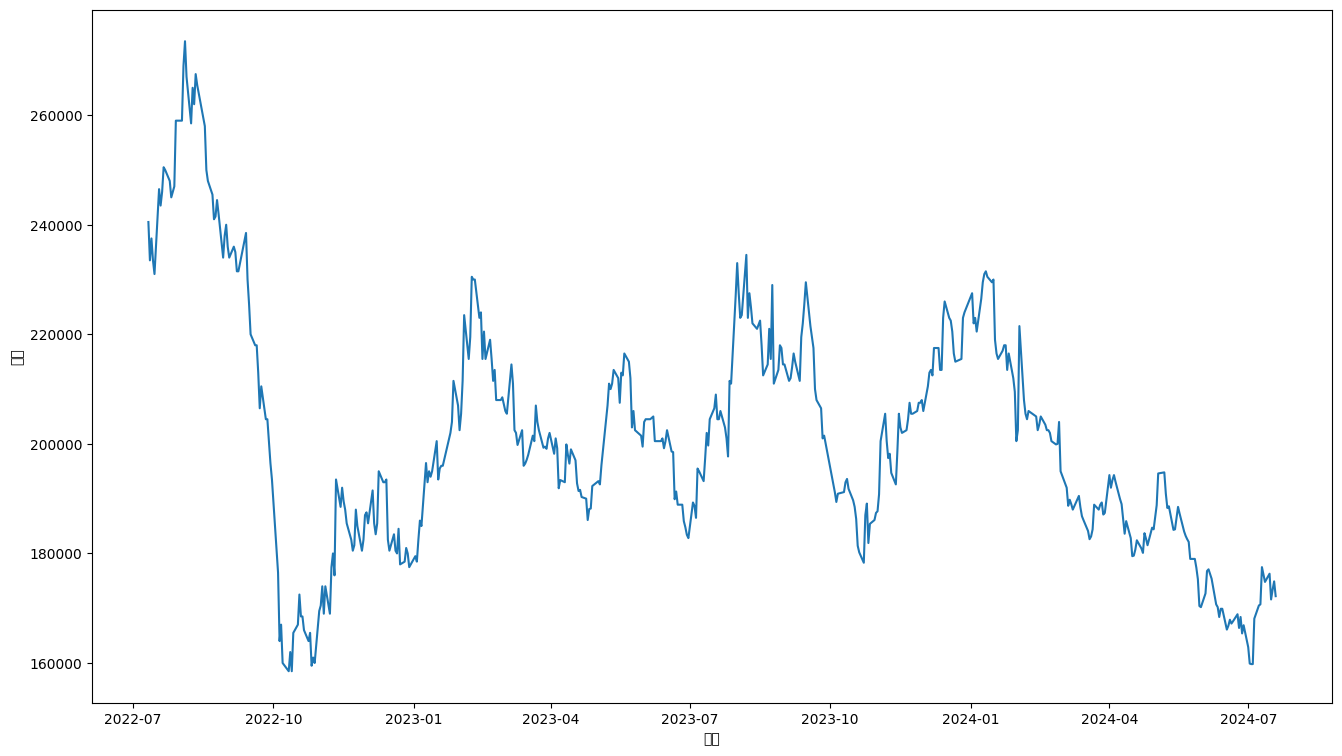

In [8]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock_price['종가'], x=stock_price['날짜'])
plt.show()

In [9]:
# minmax

scaler = MinMaxScaler()
scale_cols=['시가', '고가', '저가', '거래량']
scaled = scaler.fit_transform(stock_price[scale_cols])

scaled_stock = pd.DataFrame(scaled)

In [10]:
scaled_stock.columns = scale_cols

In [11]:
scaled_stock

,시가,고가,저가,거래량
0,0.142149,0.125103,0.127586,0.058497
1,0.138843,0.131687,0.140517,0.044368
2,0.128099,0.123457,0.143103,0.050043
3,0.157851,0.137449,0.138793,0.089472
4,0.179339,0.172840,0.181034,0.107236
...,...,...,...,...
495,0.644628,0.617284,0.629310,0.091785
496,0.623967,0.629630,0.655172,0.058053
497,0.623967,0.654321,0.663793,0.033092
498,0.661157,0.641975,0.650862,0.056560


In [12]:
end_price = np.log1p(stock_price["종가"])

In [13]:
scaled_stock["종가"] = end_price

In [14]:
train = scaled_stock[:-30]
test = scaled_stock[-30:]

In [15]:
train.shape, test.shape

((470, 5), (30, 5))

In [16]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data)- window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [17]:
train_feature = train[['시가', '고가', '저가', '거래량']]
train_label = train['종가']

test_feature = test[['시가', '고가', '저가', '거래량']]
test_label = test[['종가']]

In [18]:
train_feature, train_label = make_dataset(train_feature, train_label, 10)

# train, validation set생성
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 10)

In [19]:
test_label.shape

(20, 1)

In [20]:
train_feature.shape[1], train_feature.shape[2]

(10, 4)

In [21]:
train_feature.shape

(460, 10, 4)

In [22]:
model = keras.Sequential([
                          keras.layers.LSTM(10, input_shape=(10, 4), activation='relu'),
                          keras.layers.Dense(1)
])

In [23]:
model.compile(
    optimizer = 'adam',
    loss= 'mse',
)

In [24]:
epoch = 500
batch_size = 64

es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
cp = keras.callbacks.ModelCheckpoint('predict_juga_2.h5', monitor='val_loss', save_best_only=True)

In [25]:
history = model.fit(x_train, y_train,
                    epochs= epoch,
                    batch_size = batch_size,
                    validation_data = (x_valid, y_valid),
                    callbacks=[es, cp])

Epoch 1/500
6/6 [==============================] - 2s 75ms/step - loss: 150.3172 - val_loss: 149.8093
Epoch 2/500
6/6 [==============================] - 0s 16ms/step - loss: 149.8575 - val_loss: 149.3765
Epoch 3/500
6/6 [==============================] - 0s 13ms/step - loss: 149.4224 - val_loss: 148.9518
Epoch 4/500
1/6 [====>.........................] - ETA: 0s - loss: 149.1862

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 0s 13ms/step - loss: 148.9846 - val_loss: 148.5175
Epoch 5/500
6/6 [==============================] - 0s 19ms/step - loss: 148.5341 - val_loss: 148.0601
Epoch 6/500
6/6 [==============================] - 0s 13ms/step - loss: 148.0548 - val_loss: 147.5701
Epoch 7/500
6/6 [==============================] - 0s 16ms/step - loss: 147.5454 - val_loss: 147.0404
Epoch 8/500
6/6 [==============================] - 0s 13ms/step - loss: 146.9769 - val_loss: 146.4292
Epoch 9/500
6/6 [==============================] - 0s 16ms/step - loss: 146.2988 - val_loss: 145.6512
Epoch 10/500
6/6 [==============================] - 0s 13ms/step - loss: 145.3992 - val_loss: 144.5584
Epoch 11/500
6/6 [==============================] - 0s 15ms/step - loss: 144.1069 - val_loss: 142.9361
Epoch 12/500
6/6 [==============================] - 0s 20ms/step - loss: 142.1596 - val_loss: 140.4309
Epoch 13/500
6/6 [==============================] - 0s 13ms/step - loss: 139.1078 - val_los

In [26]:
# 최고의 모델을 가져와서 test
loaded_models = keras.models.load_model("predict_juga_2.h5")

In [27]:
pred = loaded_models.predict(test_feature)

1/1 [==============================] - 0s 212ms/step


In [28]:
pred = np.expm1(pred)

In [29]:
test_label.shape

(20, 1)

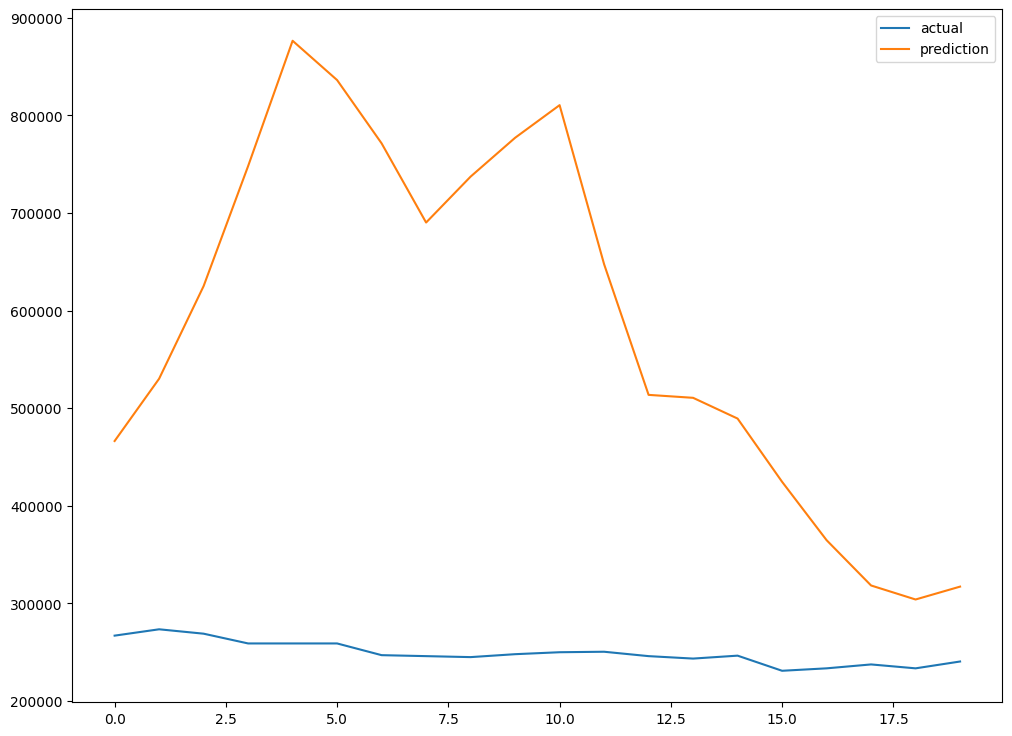

In [30]:
plt.figure(figsize=(12, 9))
plt.plot(np.expm1(test_label), label='actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()